In [35]:
# import system libs
import os
import time
import shutil

import pathlib
import itertools

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from PIL import Image
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.xception import Xception
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [33]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.3 MB/s eta 0:00:00


In [34]:
import visualkeras

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!unzip /gdrive/MyDrive/dataset/cassava-leaf.zip > /dev/null

In [5]:
train_folder = "/content/cassava-leaf-disease/train"
test_folder = "/content/cassava-leaf-disease/val"


In [6]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(train_folder))


There are 1526 files in Cassava Brown Streak Disease (CBSD)
There are 2214 files in Cassava Mosaic Disease (CMD)
There are 1663 files in Cassava Green Mottle (CGM)
There are 1797 files in Healthy
There are 757 files in Cassava Bacterial Blight (CBB)


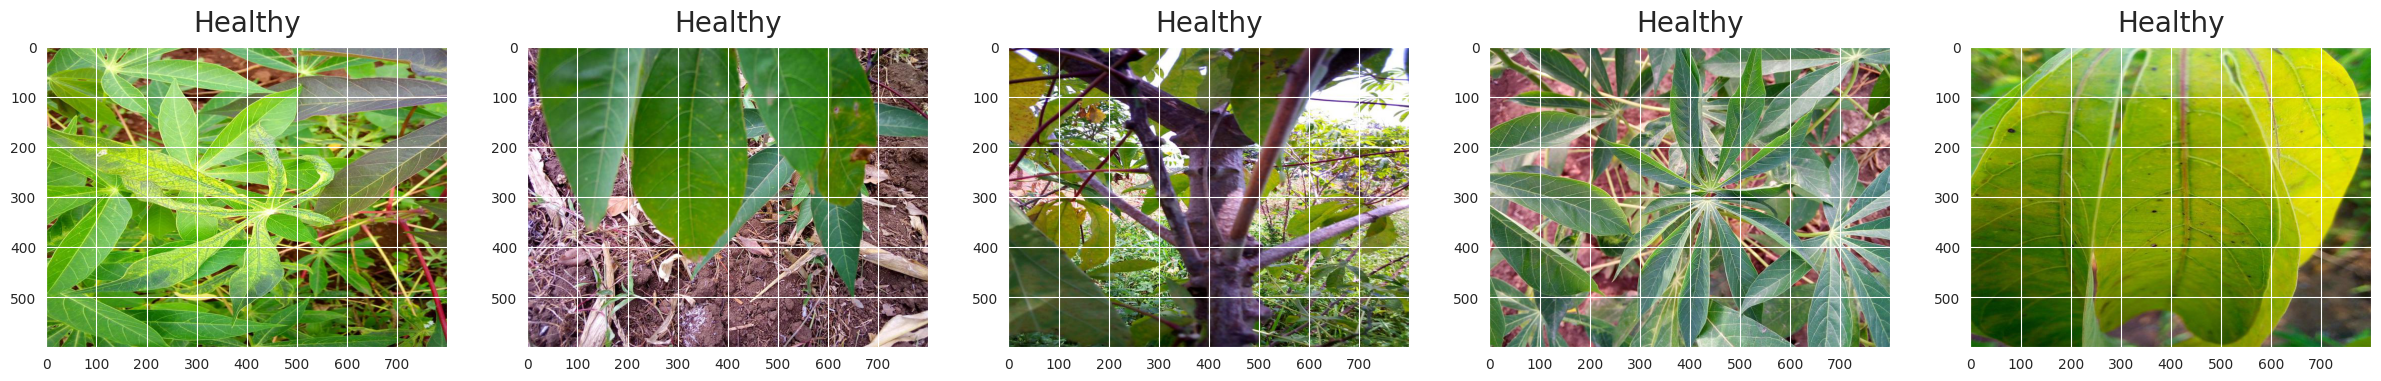

In [7]:
select_plant="Healthy"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_plant)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_plant,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_plant, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

In [36]:
def block(x, filters):
    path1 = layers.Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)
    path1 = layers.Conv2D(filters=filters[1], kernel_size=3, padding='same', activation='relu')(path1)

    path2 = layers.Conv2D(filters=filters[2], kernel_size=1, activation='relu')(x)
    path2 = layers.Conv2D(filters=filters[3], kernel_size=5, padding='same', activation='relu')(path2)

    path3 = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    path3 = layers.Conv2D(filters=filters[4], kernel_size=1, activation='relu')(path3)

    path4 = layers.Conv2D(filters=filters[5], kernel_size=1, activation='relu')(x)

    output = layers.concatenate([path1, path2, path3, path4], axis=-1)
    return output

def customnet(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu')(input_layer)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = block(x, filters=[64, 96, 128, 16, 32, 32])
    x = block(x, filters=[128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = block(x, filters=[192, 96, 208, 16, 48, 64])
    x = block(x, filters=[160, 112, 224, 24, 64, 64])
    x = block(x, filters=[128, 128, 256, 24, 64, 64])
    x = block(x, filters=[112, 144, 288, 32, 64, 64])
    x = block(x, filters=[256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = block(x, filters=[256, 160, 320, 32, 128, 128])
    x = block(x, filters=[384, 192, 384, 48, 128, 128])
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    return model

In [37]:
input_shape = (299,299, 3)  
num_classes = 5 

model = customnet(input_shape, num_classes)

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 147, 147, 32  9248        ['conv2d_4[0][0]']               
                                )                                                           

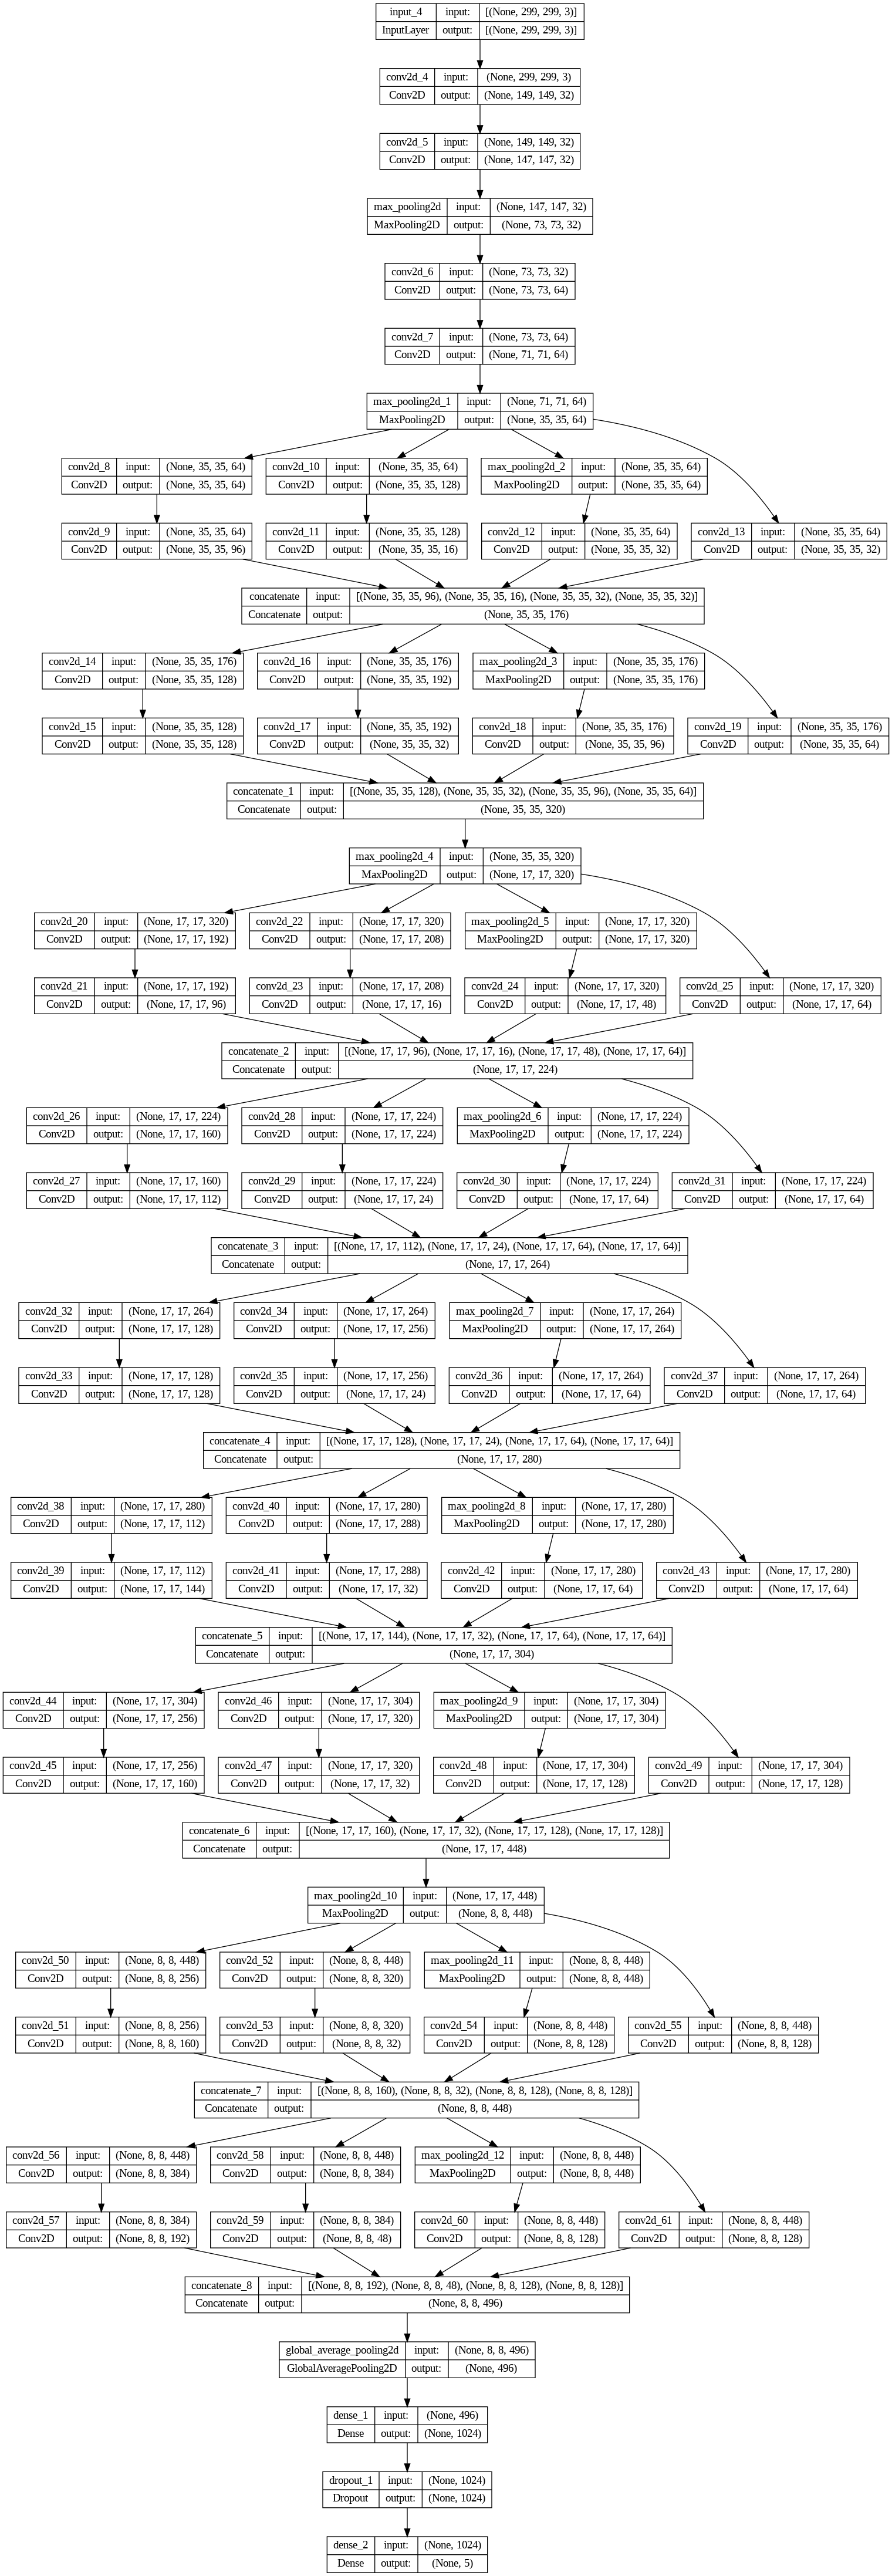

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

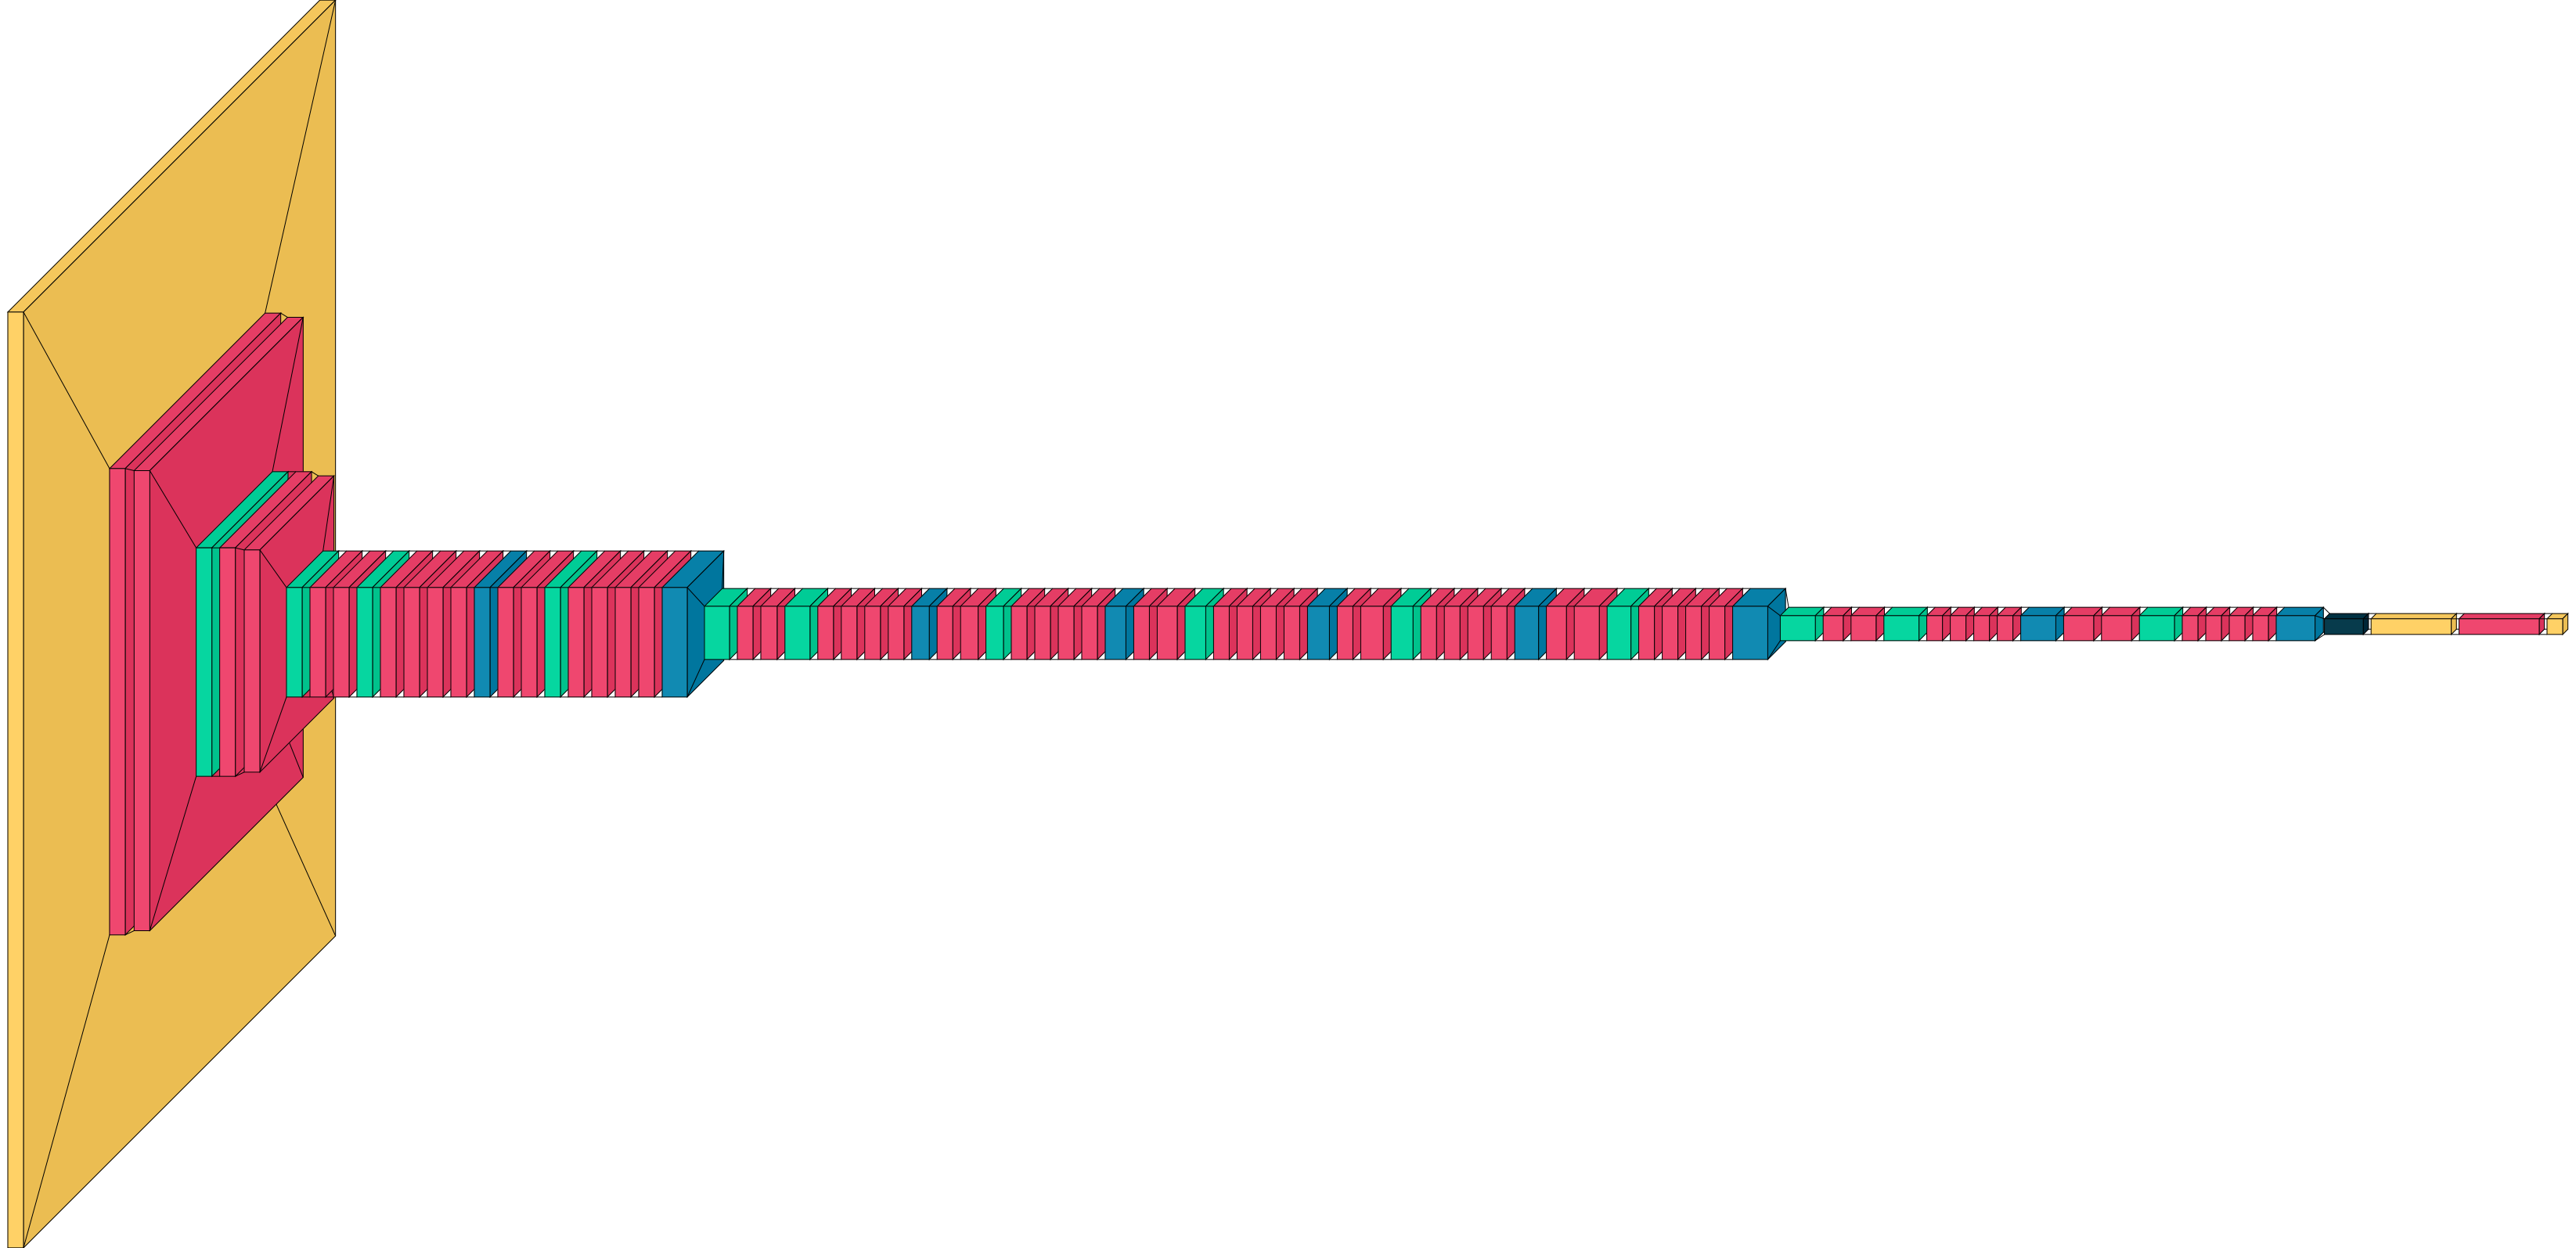

In [40]:
visualkeras.layered_view(model)

In [41]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (299, 299),
    batch_size = 48, 
    class_mode = 'categorical')

Found 7957 images belonging to 5 classes.
Found 2285 images belonging to 5 classes.


In [15]:
class_map = training_set.class_indices
class_map

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

In [42]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
95/95 [==============================] - 311s 3s/step - loss: 0.3842 - accuracy: 0.8340 - val_loss: 31.3836 - val_accuracy: 0.6009
Epoch 2/20
95/95 [==============================] - 278s 3s/step - loss: 0.1922 - accuracy: 0.9279 - val_loss: 0.1655 - val_accuracy: 0.9337
Epoch 3/20
95/95 [==============================] - 264s 3s/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 1.2556 - val_accuracy: 0.9308
Epoch 4/20
95/95 [==============================] - 264s 3s/step - loss: 0.1136 - accuracy: 0.9583 - val_loss: 0.1992 - val_accuracy: 0.9424
Epoch 5/20
95/95 [==============================] - 269s 3s/step - loss: 0.0819 - accuracy: 0.9691 - val_loss: 0.1225 - val_accuracy: 0.9597
Epoch 6/20
95/95 [==============================] - 269s 3s/step - loss: 0.0631 - accuracy: 0.9749 - val_loss: 0.1063 - val_accuracy: 0.9611
Epoch 7/20
95/95 [==============================] - 267s 3s/step - loss: 0.0620 - accuracy: 0.9777 - val_loss: 0.1826 - val_accuracy: 0.9582
Epoch 8/20
9

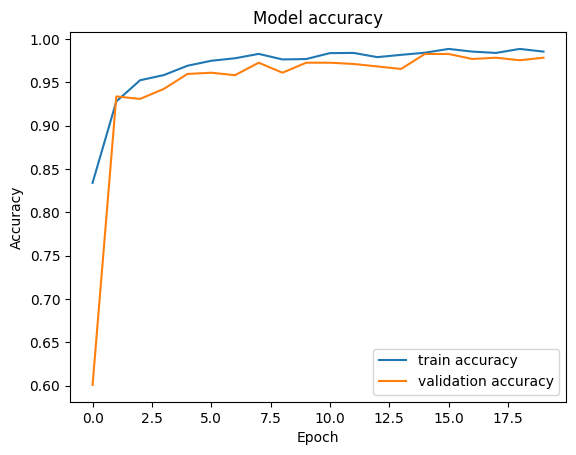

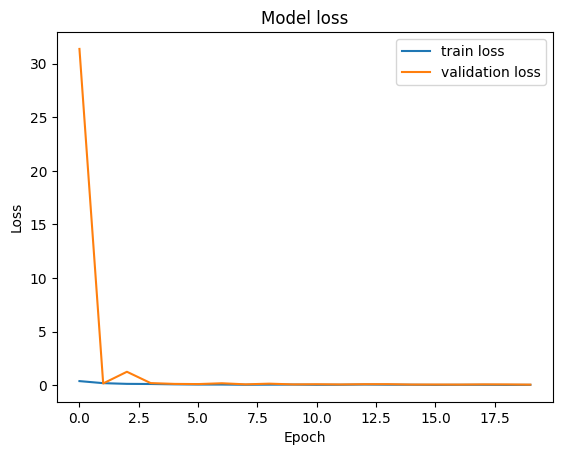

In [43]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [44]:
# Using the test dataset
score = model.evaluate_generator(test_set)
print('Test loss:', score[0])
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Test loss: 0.05535550788044

accuracy: 97.83%


In [45]:
validation_data_dir = '/content/cassava-leaf-disease/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=48,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]*100))

Found 1172 images belonging to 5 classes.
Test Accuracy: 98.082


In [22]:
category={
    0:'Cassava Bacterial Blight (CBB)',
    1:'Cassava Brown Streak Disease (CBSD)',
    2:'Cassava Green Mottle (CGM)',
    3:'Cassava Mosaic Disease (CMD)',
    4:'Healthy'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    prob = np.max(prediction)
    
    plt.title("Prediction - {} ".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        prob = np.max(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))


1/1 [==============================] - 0s 38ms/step


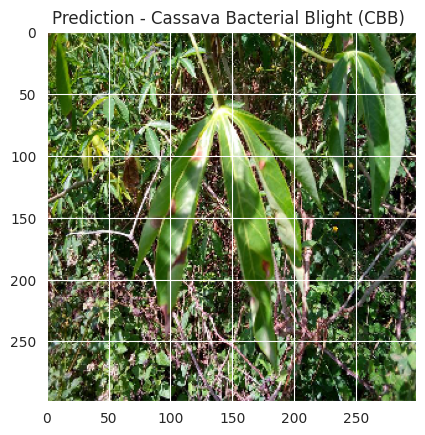

In [23]:
predict_image('/content/cassava-leaf-disease/test/Cassava Bacterial Blight (CBB)/1757057989.jpg',model)

1/1 [==============================] - 0s 105ms/step


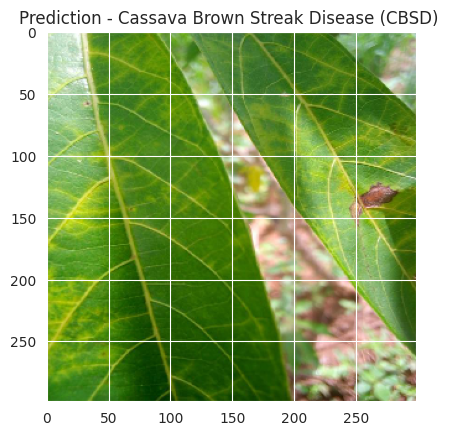

In [25]:
predict_image('/content/cassava-leaf-disease/test/Cassava Brown Streak Disease (CBSD)/1156776649.jpg',model)

1/1 [==============================] - 0s 78ms/step


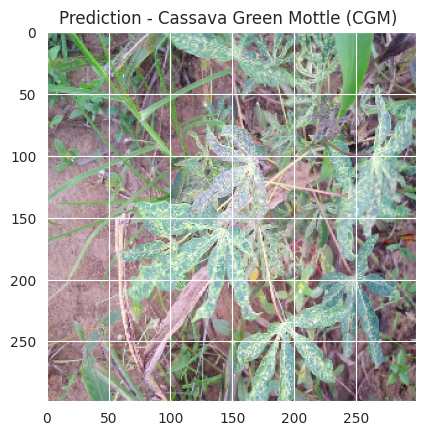

In [28]:
predict_image('/content/cassava-leaf-disease/test/Cassava Green Mottle (CGM)/788188732.jpg',model)

1/1 [==============================] - 0s 35ms/step


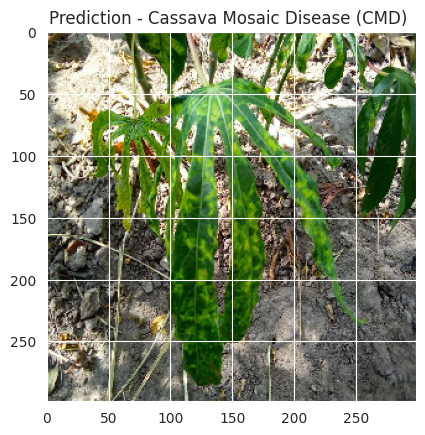

In [27]:
predict_image('/content/cassava-leaf-disease/test/Cassava Mosaic Disease (CMD)/189339781.jpg',model)

1/1 [==============================] - 0s 24ms/step


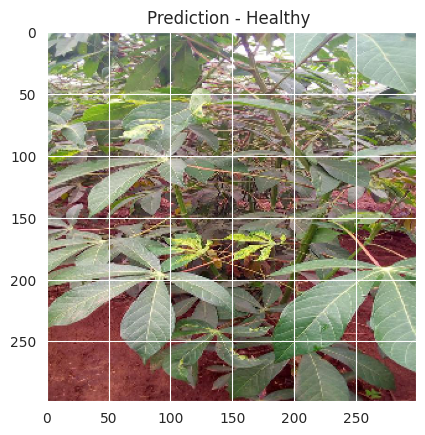

In [29]:
predict_image('/content/cassava-leaf-disease/test/Healthy/1385808202.jpg',model)

In [30]:
def labels_confusion_matrix(val_folder):
    
    folder_path=val_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 5
    cmap="OrRd"
    cm_plot_labels = [i for i in range(5)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

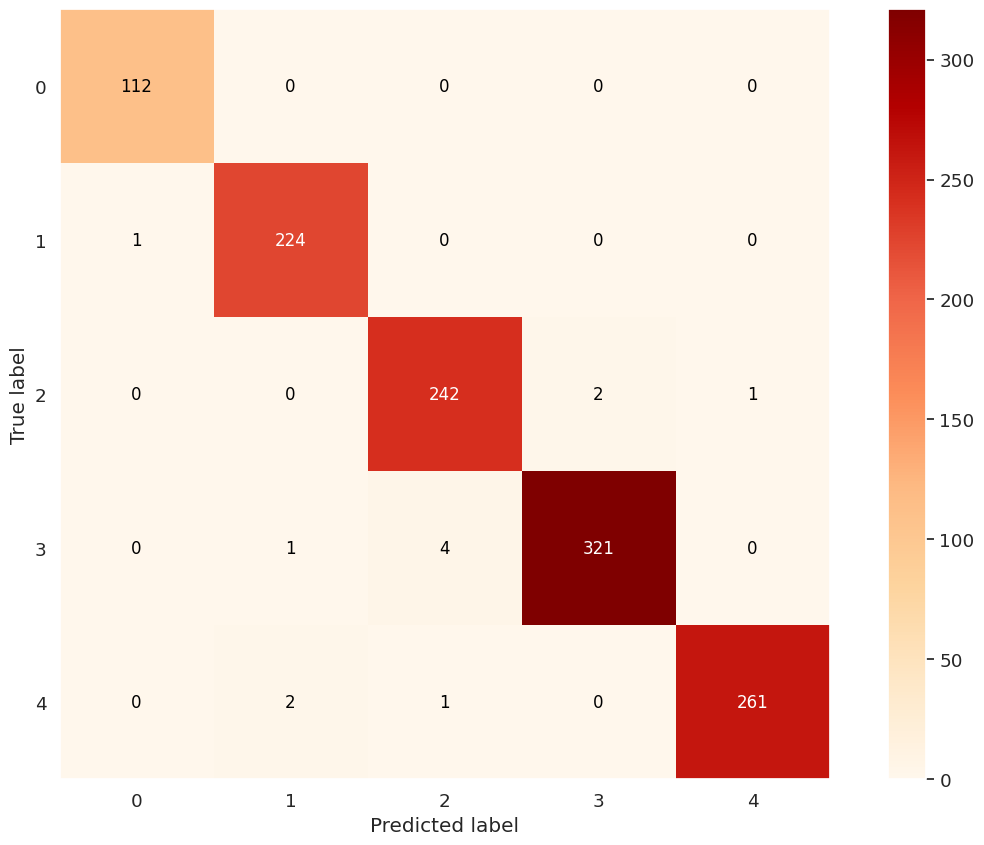

In [68]:
y_true,y_pred=labels_confusion_matrix(validation_data_dir)
print_confusion_matrix(y_true,y_pred)

In [63]:
from sklearn.metrics import confusion_matrix,classification_report
y_true,y_pred=labels_confusion_matrix(validation_data_dir)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       0.99      0.99      0.98       225
           2       0.98      0.99      0.99       245
           3       0.99      0.98      0.98       326
           4       0.98      0.99      0.99       264

    accuracy                           0.98      1172
   macro avg       0.98      0.98      0.98      1172
weighted avg       0.99      0.99      0.99      1172

